We will be using Keras both for the data and for quick prototyping of the network. TensorFlow will also be used to define the activation functions.

In [1]:
from __future__ import print_function
from keras.datasets import mnist
from keras.utils import np_utils
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


In [2]:
def show_random():
    i = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[i,:,:], cmap='Greys')
    print(y_train[i])

7


/usr/local/lib/python2.7/dist-packages/numpy-1.11.0b2-py2.7-linux-x86_64.egg/numpy/ma/core.py:3113: FutureWarning: Currently, slicing will try to return a view of the data, but will return a copy of the mask. In the future, it will try to return both as views.
  FutureWarning


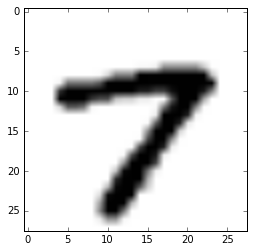

In [3]:
show_random()

We won't be using spatial information, so we can flatten the 28 by 28 images to 28^2 dimensional vectors.

In [4]:
X_train = X_train.reshape(X_train.shape[0],
                          X_train.shape[1]**2)
X_test = X_test.reshape(X_test.shape[0],
                        X_test.shape[1]**2)
print(X_train.shape)
print(y_train.shape)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)


(60000, 784)
(60000,)


Finally, lets shuffle the training data.

In [5]:
perm = np.random.permutation(np.arange(X_train.shape[0]))
X_train = X_train[perm, :]
Y_train = Y_train[perm]

Lets use Keras' generalized backend to define activation functions.

In [6]:
import keras.backend as K

def sigmoid(x):
    return K.sigmoid(x)
def tanh(x):
    return K.tanh(x)
def softsign(x):
    return x/(K.abs(x)+1.)
def relu(x):
    return K.relu(x)

Using TensorFlow backend.


Lets run these activiation functions over some values to make sure they are right...

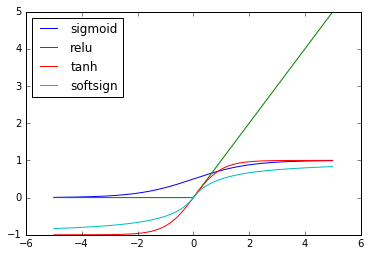

In [7]:
act_funs = [sigmoid, relu, tanh, softsign,]
for a in act_funs:
    xs = np.float32(np.arange(-5, 5, .01))
    a(xs)
    ys = K.eval(a(xs))
    plt.plot(xs, ys, label = a.__name__)
plt.legend(loc=0)
plt.show()

Good -- these activations look right! Now we can make a quick 5 layer neural network using the experimental parameters described in the paper... 

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.initializations import uniform
from collections import defaultdict
from IPython import display

n_hidden = 4
assert n_hidden > 0
hidden_dim = 100
batch_size = 10
lr = .1 #this is terrible. please optimize hyperparameters or use a better optimizer
n_epoch = 60

def make_model(n_hidden, hidden_dim, act_fun):
    model = Sequential()
    prev_shape = X_train.shape[1]
    print("Adding {} to {}".format(X_train.shape[1], hidden_dim))
    model.add(Dense(hidden_dim, input_dim = X_train.shape[1],
                    init= lambda shape: uniform(shape,
                                                scale = 1/np.sqrt(prev_shape)),
                    activation = act_fun))
    prev_shape = hidden_dim
    for _ in range(n_hidden-1):
        print("Adding {} to {}".format(prev_shape, hidden_dim))
        model.add(Dense(hidden_dim,
                       init=lambda shape: uniform(shape,
                                                  scale = 1/np.sqrt(prev_shape)),
                       activation = act_fun))
        prev_shape = hidden_dim
    print("Adding {} to {}".format(prev_shape, 10))
    model.add(Dense(10, init=lambda shape: uniform(shape,
                                                  scale = 1/np.sqrt(prev_shape))))
    model.add(Activation('softmax'))
    return model

def make_activation_plot(act_fun):
    model = make_model(n_hidden, hidden_dim, act_fun)
    sgd = SGD(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=sgd)

    get_act_fs = [K.function([model.get_input(train=False)],
                            [model.layers[i].get_output(train=False)])
                  for i in range(len(model.layers)-2)]
    random_batch = X_test[:300,:]
    means = defaultdict(list)
    for e in range(n_epoch):
        acts = []
        for f in get_act_fs:
            acts.append(f([random_batch]))
        acts = [a[0] for a in acts]
        print([a.shape for a in acts])
        for i, a in enumerate(acts):
            data = a.flatten()
            means[i].append(np.mean(data))
        plt.clf()
        for layer_num in means.keys():
            n_points = len(means[layer_num])
            plt.plot(np.arange(n_points), means[layer_num],
                         label = "Layer {}".format(layer_num+1),
                        linewidth=2.0)
        plt.legend(loc = 0)
        plt.title(act_fun.__name__)
        plt.xlim(-.5, n_points + .5)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        model.fit(X_train, Y_train, batch_size = batch_size, nb_epoch = 1,
                    validation_split=.2, shuffle = False, verbose = 0)
    plt.savefig(act_fun.__name__ + str(e) + ".png")
        

In [ ]:
for a in act_funs:
    make_activation_plot(a)